# BIOSTAT 826 - Assignment 1
Mortality prediction in MIMIC-IV using ICD-10 diagnosis and procedure categories.

## Setup

In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

sys.path.append(str(Path.cwd().parent))

from utils.data import assemble_dataset, load_code_descriptions
from utils.evaluation import (
    TemperatureScaler,
    bootstrap_metric_ci,
    calibration_curve_quantile,
    calibration_slope_intercept,
    compute_basic_metrics,
    sigmoid,
    specificity_at_sensitivity,
)
from utils.training import (
    LogisticRegressionModel,
    MLPRiskModel,
    build_dataloader,
    coefficient_table,
    extract_linear_weights,
    predict_logits,
    set_seed,
    train_lr_sweep_with_models,
    train_model,
    tune_l1_strength,
)

In [2]:
set_seed(826)
data_dir = Path('/home/rl/mimic-iv-3.1/mimic-iv-3.1/hosp')
bundle = assemble_dataset(data_dir, min_count=10, seed=826)
desc = load_code_descriptions(data_dir)

X = bundle.X
y = bundle.y.astype(np.float32)
splits = bundle.splits
feature_names = bundle.feature_names

X_train, y_train = X[splits['train']], y[splits['train']]
X_val, y_val = X[splits['val']], y[splits['val']]
X_cal, y_cal = X[splits['cal']], y[splits['cal']]
X_test, y_test = X[splits['test']], y[splits['test']]

print('n_admissions:', X.shape[0])
print('n_features:', X.shape[1])
print('mortality_rate:', float(y.mean()))

n_admissions: 546028
n_features: 1859
mortality_rate: 0.021612444892525673


### Feature scaling for MLP
Use train-set standardization (no centering for sparse matrix). We keep raw binary features for LR interpretability, and use scaled features for MLP fitting stability.

In [3]:
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_cal_scaled = scaler.transform(X_cal)
X_test_scaled = scaler.transform(X_test)

## Part 2 - Logistic Regression

### LR sweep means trying multiple learning rates
Here we train the same logistic regression with different learning rates and compare optimization behavior.

In [4]:
train_loader = build_dataloader(X_train, y_train, batch_size=200, shuffle=True)
val_loader = build_dataloader(X_val, y_val, batch_size=200, shuffle=False)
cal_loader = build_dataloader(X_cal, y_cal, batch_size=200, shuffle=False)
test_loader = build_dataloader(X_test, y_test, batch_size=200, shuffle=False)

In [5]:
lrs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
lr_sweep = train_lr_sweep_with_models(
    lambda: LogisticRegressionModel(X.shape[1]),
    train_loader,
    val_loader,
    lrs,
    max_epochs=40,
    patience=6,
)

lr_summary = []
for lr, trained in lr_sweep.items():
    lr_summary.append({
        'lr': lr,
        'epochs': len(trained.result.history['epoch_train_loss']),
        'best_epoch': trained.result.best_epoch,
        'best_val_loss': min(trained.result.history['val_loss']),
    })
lr_summary_df = pd.DataFrame(lr_summary).sort_values('lr').reset_index(drop=True)
lr_summary_df

,lr,epochs,best_epoch,best_val_loss
0,0.00001,40,39,0.540726
1,0.00010,40,39,0.199965
2,0.00100,40,39,0.100084
3,0.01000,40,39,0.084818
4,0.10000,40,39,0.081106


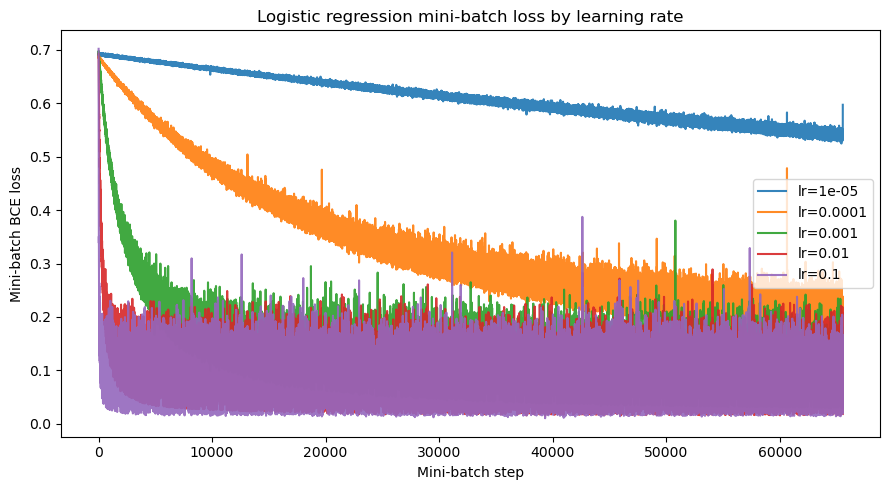

In [6]:
plt.figure(figsize=(9, 5))
for lr, trained in lr_sweep.items():
    plt.plot(trained.result.history['batch_train_loss'], label=f'lr={lr:g}', alpha=0.9)
plt.xlabel('Mini-batch step')
plt.ylabel('Mini-batch BCE loss')
plt.title('Logistic regression mini-batch loss by learning rate')
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
best_lr = float(lr_summary_df.sort_values('best_val_loss').iloc[0]['lr'])
lr_best_model = lr_sweep[best_lr].model
lr_best_weights = extract_linear_weights(lr_best_model)
lr_top20, lr_bottom20 = coefficient_table(lr_best_weights, feature_names, desc, top_k=20)

print(f'Best LR by validation loss: {best_lr:g}')
print('Top 20 categories increasing log-odds')
display(lr_top20)
print('Top 20 categories decreasing log-odds')
display(lr_bottom20)

Best LR by validation loss: 0.1
Top 20 categories increasing log-odds


,category,weight,long_title
0,D_R40,1.354785,"Somnolence, stupor and coma"
1,D_K72,1.031416,"Hepatic failure, not elsewhere classified"
2,D_R65,0.958265,Symptoms and signs specifically associated wit...
3,D_G91,0.948625,Hydrocephalus
4,D_D65,0.933843,Disseminated intravascular coagulation [defibr...
5,P_03H,0.916844,"Upper Arteries, Insertion"
6,P_5A0,0.831541,Extracorporeal or Systemic Assistance and Perf...
7,D_N17,0.790698,Acute kidney failure
8,D_C78,0.741869,Secondary malignant neoplasm of respiratory an...
9,D_K55,0.729009,Vascular disorders of intestine


Top 20 categories decreasing log-odds


,category,weight,long_title
0,P_0JH,-1.257802,"Subcutaneous Tissue and Fascia, Insertion"
1,D_Z23,-1.126126,Encounter for immunization
2,D_R07,-0.710693,Pain in throat and chest
3,D_Z3A,-0.679673,Weeks of gestation
4,D_R13,-0.649192,Aphagia and dysphagia
5,P_0B1,-0.602742,"Respiratory System, Bypass"
6,D_M25,-0.550135,"Other joint disorder, not elsewhere classified"
7,D_F17,-0.543256,Nicotine dependence
8,D_Z79,-0.538359,Long term (current) drug therapy
9,P_B24,-0.520297,"Imaging, Heart, Ultrasonography"


In [8]:
l1_grid = [0.0, 1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3]
chosen_l1, l1_trained, l1_table = tune_l1_strength(
    lambda: LogisticRegressionModel(X.shape[1]),
    train_loader,
    val_loader,
    l1_grid,
    target_sparsity=0.85,
    lr=best_lr,
    max_epochs=40,
    patience=6,
)

print('Chosen L1 lambda:', chosen_l1)
l1_table

Chosen L1 lambda: 0.0003


,l1_lambda,sparsity,best_val_loss
0,0.000000,0.002152,0.081094
1,0.000001,0.060785,0.081120
2,0.000003,0.253362,0.081171
3,0.000010,0.484131,0.081350
4,0.000030,0.643895,0.081918
5,0.000100,0.782141,0.083586
6,0.000300,0.860678,0.086570
7,0.001000,0.942980,0.091116


In [9]:
l1_weights = extract_linear_weights(l1_trained.model)
l1_top20, l1_bottom20 = coefficient_table(l1_weights, feature_names, desc, top_k=20)

print('L1 model top 20 categories increasing log-odds')
display(l1_top20)
print('L1 model top 20 categories decreasing log-odds')
display(l1_bottom20)

L1 model top 20 categories increasing log-odds


,category,weight,long_title
0,D_R65,0.960752,Symptoms and signs specifically associated wit...
1,D_R40,0.938181,"Somnolence, stupor and coma"
2,D_K72,0.885309,"Hepatic failure, not elsewhere classified"
3,D_E87,0.666649,"Other disorders of fluid, electrolyte and acid..."
4,P_03H,0.655615,"Upper Arteries, Insertion"
5,D_N17,0.624007,Acute kidney failure
6,D_C78,0.490207,Secondary malignant neoplasm of respiratory an...
7,D_I48,0.489653,Atrial fibrillation and flutter
8,P_02H,0.476018,"Heart and Great Vessels, Insertion"
9,D_J18,0.438690,"Pneumonia, unspecified organism"


L1 model top 20 categories decreasing log-odds


,category,weight,long_title
0,D_Z79,-0.355104,Long term (current) drug therapy
1,D_F32,-0.302377,Depressive episode
2,D_Z20,-0.292702,Contact with and (suspected) exposure to commu...
3,D_Z23,-0.281541,Encounter for immunization
4,P_0JH,-0.250108,"Subcutaneous Tissue and Fascia, Insertion"
5,D_K21,-0.227106,Gastro-esophageal reflux disease
6,D_F17,-0.218445,Nicotine dependence
7,D_E66,-0.195418,Overweight and obesity
8,D_G47,-0.185650,Sleep disorders
9,D_J45,-0.151823,Asthma


## Part 3 - Neural Network Risk Predictor

In [10]:
def run_nn_experiments(X_train_local, y_train_local, X_val_local, y_val_local, hidden_sizes):
    train_local = build_dataloader(X_train_local, y_train_local, batch_size=200, shuffle=True)
    val_local = build_dataloader(X_val_local, y_val_local, batch_size=200, shuffle=False)
    results = {}
    for hidden_dim in hidden_sizes:
        model = MLPRiskModel(X.shape[1], hidden_dim=hidden_dim)
        result = train_model(
            model,
            train_local,
            val_local,
            lr=1e-3,
            max_epochs=35,
            patience=6,
        )
        results[hidden_dim] = {'model': model, 'result': result}
    return results

In [11]:
hidden_sizes = [100, 1000, 5000]
nn_full = run_nn_experiments(X_train_scaled, y_train, X_val_scaled, y_val, hidden_sizes)

nn_full_summary = []
for h, item in nn_full.items():
    nn_full_summary.append({
        'hidden_size': h,
        'epochs': len(item['result'].history['epoch_train_loss']),
        'best_epoch': item['result'].best_epoch,
        'best_val_loss': min(item['result'].history['val_loss']),
    })
nn_full_summary_df = pd.DataFrame(nn_full_summary).sort_values('hidden_size').reset_index(drop=True)
nn_full_summary_df

,hidden_size,epochs,best_epoch,best_val_loss
0,100,35,34,0.081999
1,1000,35,34,0.082928
2,5000,35,34,0.083010


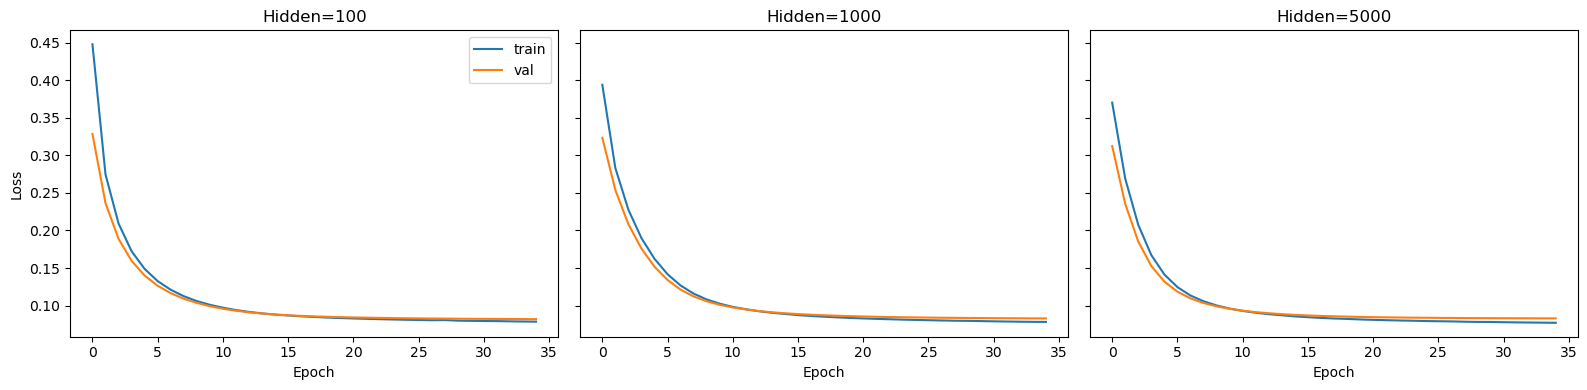

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
for i, h in enumerate(hidden_sizes):
    hist = nn_full[h]['result'].history
    axes[i].plot(hist['epoch_train_loss'], label='train')
    axes[i].plot(hist['val_loss'], label='val')
    axes[i].set_title(f'Hidden={h}')
    axes[i].set_xlabel('Epoch')
    if i == 0:
        axes[i].set_ylabel('Loss')
        axes[i].legend()
plt.tight_layout()
plt.show()

In [13]:
rng = np.random.default_rng(826)
downsample_n = max(1, len(y_train) // 10)
down_idx = rng.choice(np.arange(len(y_train)), size=downsample_n, replace=False)
X_train_down = X_train_scaled[down_idx]
y_train_down = y_train[down_idx]

nn_down = run_nn_experiments(X_train_down, y_train_down, X_val_scaled, y_val, hidden_sizes)

nn_down_summary = []
for h, item in nn_down.items():
    nn_down_summary.append({
        'hidden_size': h,
        'epochs': len(item['result'].history['epoch_train_loss']),
        'best_epoch': item['result'].best_epoch,
        'best_val_loss': min(item['result'].history['val_loss']),
    })
nn_down_summary_df = pd.DataFrame(nn_down_summary).sort_values('hidden_size').reset_index(drop=True)
nn_down_summary_df

,hidden_size,epochs,best_epoch,best_val_loss
0,100,35,34,0.173169
1,1000,35,34,0.188857
2,5000,35,34,0.169443


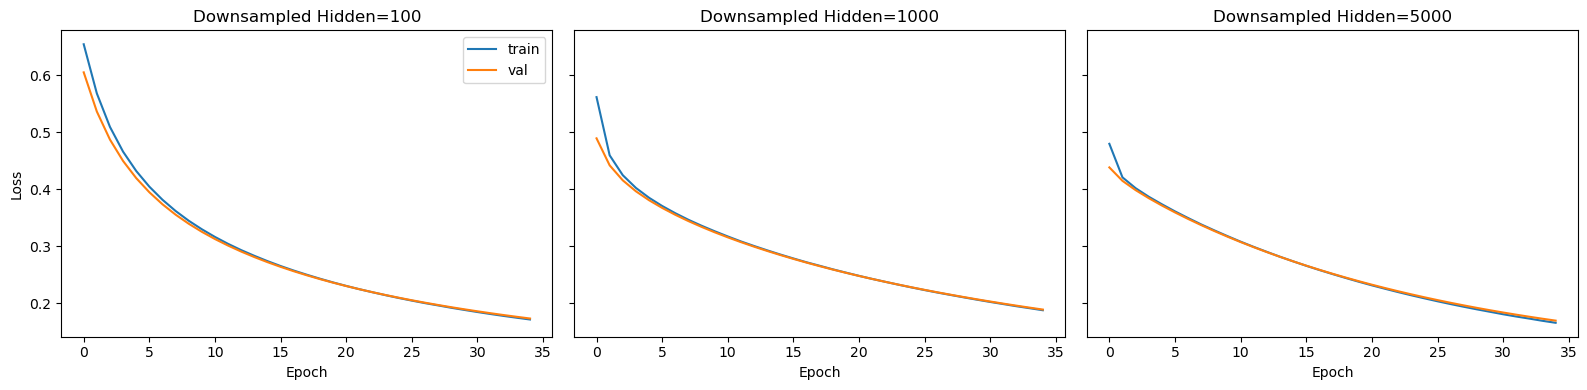

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
for i, h in enumerate(hidden_sizes):
    hist = nn_down[h]['result'].history
    axes[i].plot(hist['epoch_train_loss'], label='train')
    axes[i].plot(hist['val_loss'], label='val')
    axes[i].set_title(f'Downsampled Hidden={h}')
    axes[i].set_xlabel('Epoch')
    if i == 0:
        axes[i].set_ylabel('Loss')
        axes[i].legend()
plt.tight_layout()
plt.show()

## Part 4 - Performance Evaluation

In [15]:
best_nn_hidden = int(nn_full_summary_df.sort_values('best_val_loss').iloc[0]['hidden_size'])
nn_best_model = nn_full[best_nn_hidden]['model']

lr_logits_cal = predict_logits(lr_best_model, cal_loader)
lr_logits_test = predict_logits(lr_best_model, test_loader)
nn_cal_loader = build_dataloader(X_cal_scaled, y_cal, batch_size=200, shuffle=False)
nn_test_loader = build_dataloader(X_test_scaled, y_test, batch_size=200, shuffle=False)
nn_logits_cal = predict_logits(nn_best_model, nn_cal_loader)
nn_logits_test = predict_logits(nn_best_model, nn_test_loader)

lr_scaler = TemperatureScaler()
nn_scaler = TemperatureScaler()
lr_temp = lr_scaler.fit(lr_logits_cal, y_cal)
nn_temp = nn_scaler.fit(nn_logits_cal, y_cal)

lr_prob_raw = sigmoid(lr_logits_test)
lr_prob_cal = sigmoid(lr_logits_test / lr_temp)
nn_prob_raw = sigmoid(nn_logits_test)
nn_prob_cal = sigmoid(nn_logits_test / nn_temp)

print('Best NN hidden size:', best_nn_hidden)
print('Temperature LR:', lr_temp)
print('Temperature NN:', nn_temp)

Best NN hidden size: 100
Temperature LR: 0.9874790906906128
Temperature NN: 0.994209349155426


In [16]:
candidate_sens = [0.80, 0.85, 0.90]
sens_rows = []
for target in candidate_sens:
    lr_sens, lr_spec, _ = specificity_at_sensitivity(y_test, lr_prob_cal, target)
    nn_sens, nn_spec, _ = specificity_at_sensitivity(y_test, nn_prob_cal, target)
    sens_rows.append({
        'target_sensitivity': target,
        'lr_specificity': lr_spec,
        'nn_specificity': nn_spec,
        'mean_specificity': (lr_spec + nn_spec) / 2.0,
    })
sens_df = pd.DataFrame(sens_rows).sort_values('mean_specificity', ascending=False).reset_index(drop=True)
fixed_sensitivity = float(sens_df.iloc[0]['target_sensitivity'])
print('Selected fixed sensitivity:', fixed_sensitivity)
sens_df

Selected fixed sensitivity: 0.8


,target_sensitivity,lr_specificity,nn_specificity,mean_specificity
0,0.80,0.364712,0.396692,0.380702
1,0.85,0.364712,0.396692,0.380702
2,0.90,0.364712,0.396692,0.380702


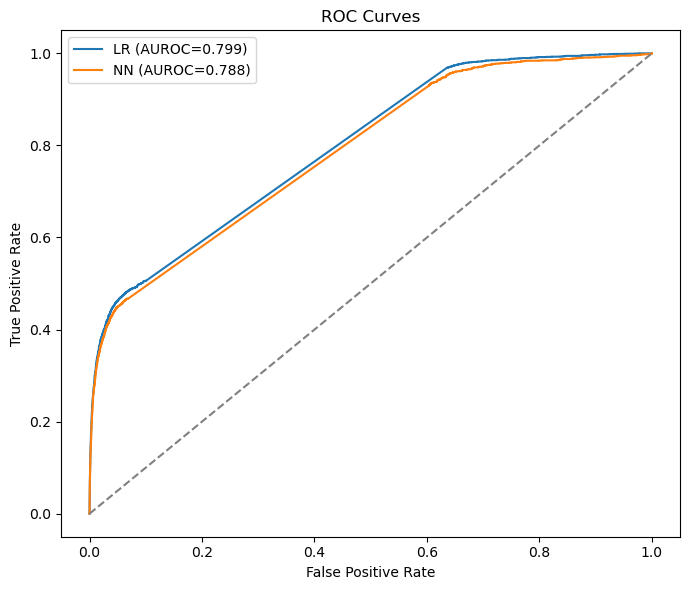

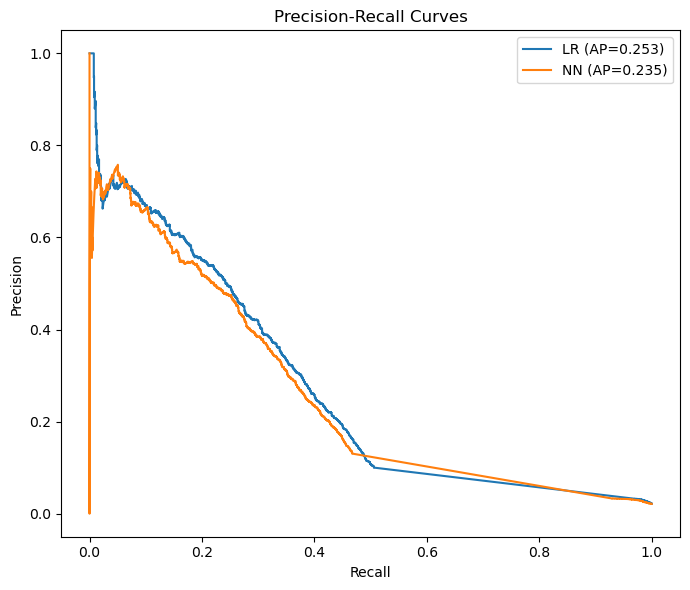

In [17]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_prob_cal)
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_prob_cal)

prec_lr, rec_lr, _ = precision_recall_curve(y_test, lr_prob_cal)
prec_nn, rec_nn, _ = precision_recall_curve(y_test, nn_prob_cal)

plt.figure(figsize=(7, 6))
plt.plot(fpr_lr, tpr_lr, label=f'LR (AUROC={roc_auc_score(y_test, lr_prob_cal):.3f})')
plt.plot(fpr_nn, tpr_nn, label=f'NN (AUROC={roc_auc_score(y_test, nn_prob_cal):.3f})')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 6))
plt.plot(rec_lr, prec_lr, label=f'LR (AP={average_precision_score(y_test, lr_prob_cal):.3f})')
plt.plot(rec_nn, prec_nn, label=f'NN (AP={average_precision_score(y_test, nn_prob_cal):.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.tight_layout()
plt.show()

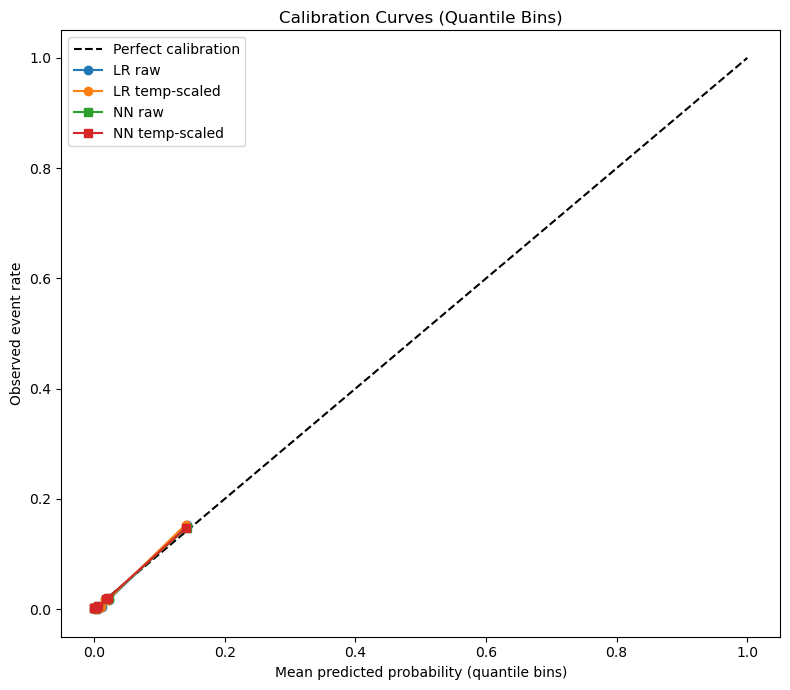

In [18]:
lr_curve_raw = calibration_curve_quantile(y_test, lr_prob_raw, n_bins=15)
lr_curve_cal = calibration_curve_quantile(y_test, lr_prob_cal, n_bins=15)
nn_curve_raw = calibration_curve_quantile(y_test, nn_prob_raw, n_bins=15)
nn_curve_cal = calibration_curve_quantile(y_test, nn_prob_cal, n_bins=15)

plt.figure(figsize=(8, 7))
plt.plot([0, 1], [0, 1], '--', color='black', label='Perfect calibration')
plt.plot(lr_curve_raw['mean_pred'], lr_curve_raw['frac_pos'], 'o-', label='LR raw')
plt.plot(lr_curve_cal['mean_pred'], lr_curve_cal['frac_pos'], 'o-', label='LR temp-scaled')
plt.plot(nn_curve_raw['mean_pred'], nn_curve_raw['frac_pos'], 's-', label='NN raw')
plt.plot(nn_curve_cal['mean_pred'], nn_curve_cal['frac_pos'], 's-', label='NN temp-scaled')
plt.xlabel('Mean predicted probability (quantile bins)')
plt.ylabel('Observed event rate')
plt.title('Calibration Curves (Quantile Bins)')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
def metric_auroc(y_true, y_prob):
    return roc_auc_score(y_true, y_prob)

def metric_ap(y_true, y_prob):
    return average_precision_score(y_true, y_prob)

def metric_cal_slope(y_true, y_prob):
    slope, _ = calibration_slope_intercept(y_true, y_prob)
    return slope

def metric_cal_intercept(y_true, y_prob):
    _, intercept = calibration_slope_intercept(y_true, y_prob)
    return intercept

def metric_spec_at_fixed_sens(y_true, y_prob):
    _, spec, _ = specificity_at_sensitivity(y_true, y_prob, fixed_sensitivity)
    return spec

In [20]:
def summarize_with_bootstrap(model_name, y_true, y_prob, n_bootstrap=1000):
    metrics = {
        'AUROC': metric_auroc,
        'AP': metric_ap,
        'Calibration slope': metric_cal_slope,
        'Calibration intercept': metric_cal_intercept,
        f'Specificity @ sensitivity={fixed_sensitivity:.2f}': metric_spec_at_fixed_sens,
    }
    rows = []
    for metric_name, fn in metrics.items():
        point, (lo, hi), _ = bootstrap_metric_ci(
            y_true,
            y_prob,
            fn,
            n_bootstrap=n_bootstrap,
            seed=826,
        )
        rows.append({
            'model': model_name,
            'metric': metric_name,
            'estimate': point,
            'ci_lower': lo,
            'ci_upper': hi,
        })
    return pd.DataFrame(rows)

result_lr = summarize_with_bootstrap('Logistic Regression', y_test, lr_prob_cal, n_bootstrap=1000)
result_nn = summarize_with_bootstrap('Neural Network', y_test, nn_prob_cal, n_bootstrap=1000)
results_df = pd.concat([result_lr, result_nn], ignore_index=True)
results_df

,model,metric,estimate,ci_lower,ci_upper
0,Logistic Regression,AUROC,0.798670,0.790433,0.806599
1,Logistic Regression,AP,0.252700,0.232641,0.273130
2,Logistic Regression,Calibration slope,1.035094,1.003546,1.068973
3,Logistic Regression,Calibration intercept,0.134488,0.015819,0.264795
4,Logistic Regression,Specificity @ sensitivity=0.80,0.364712,0.361881,0.367533
5,Neural Network,AUROC,0.788476,0.780190,0.796854
6,Neural Network,AP,0.234932,0.216495,0.255821
7,Neural Network,Calibration slope,0.999043,0.966865,1.032993
8,Neural Network,Calibration intercept,-0.005484,-0.120822,0.113035
9,Neural Network,Specificity @ sensitivity=0.80,0.396692,0.393663,0.399544
